In [1]:
import matplotlib.pyplot as plt
import numpy as np
import scipy . optimize as opt
from scipy.io import loadmat

In [2]:
weights = loadmat('.\p4\ex4weights.mat')
data = loadmat('.\p4\ex4data1.mat')
Theta1, Theta2 = weights['Theta1'], weights['Theta2']

# Vector 'y' como matriz one-hot

In [3]:
y = data['y'].ravel() #aplana el vector
X = data['X']

m = len(y)
input_size = X.shape[1]
num_labels = 10

y = (y-1)
y_onehot = np.zeros((m, num_labels))

for i in range(m):
    y_onehot[i][y[i]] = 1

# Visualizacion de datos

In [4]:
def displayData(X):
    num_plots = int(np.size(X, 0)**.5)
    fig, ax = plt.subplots(num_plots, num_plots, sharex=True, sharey=True)
    plt.subplots_adjust(left=0, wspace=0, hspace=0)
    img_num = 0
    for i in range(num_plots):
        for j in range(num_plots):
            # Convert column vector into 20x20 pixel matrix
            # transpose
            img = X[img_num, :].reshape(20, 20).T
            ax[i][j].imshow(img, cmap='Greys')
            ax[i][j].set_axis_off()
            img_num += 1

    return (fig, ax)

In [18]:
#seleccionamos elementos aleatorios
sample = np.random.choice(X.shape[0],101)

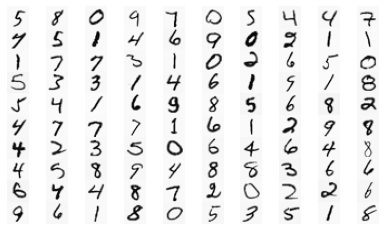

In [19]:
d = displayData(X[sample,:])

---

# Funcion sigmoide

In [4]:
def sigmoide(z):
    """
    Devuelve la función sigmoide dado un valor
    Parámetros:
    z    -- numero, array o matriz
    """
    return 1/(1 + np.exp(-z))

# Funcion de coste

## Propagacion hacia adelante

In [5]:
def propagacion_hacia_delante(k,matriz1,matriz2):
    m = k.shape[0]
    
    a1 = np.hstack([np.ones([m, 1]), k]) 
    z2 = np.dot(a1, matriz1.T)
    a2 = np.hstack([np.ones([m, 1]), sigmoide(z2)])
    z3 = sigmoide(np.dot(a2, matriz2.T))
    
    return a1, a2, z3

In [6]:
def coste_red_neuronal(Y, x, matriz1, matriz2, lambd):
    m = x.shape[0]
    
    A1,A2,Z3 = propagacion_hacia_delante(x,matriz1,matriz2)
    coste = (-1/m) * np.sum( Y * np.log(Z3) + (1 - Y) * np.log(1 - Z3 + 1e-6) ) 
    t_reg = (lambd/(2*m)) * ( np.sum(matriz1[:,1:]**2) + np.sum(matriz2[:,1:]**2) )
    
    return coste + t_reg

In [170]:
coste_red_neuronal(y_onehot,X,Theta1,Theta2,1)

0.38376070559687425

# Calculo gradiente

## Propagacion hacia atras

### Parametros

In [18]:
#params = np.concatenate((Theta1.ravel(),Theta2.ravel()))
params = np.append(Theta1, Theta2).reshape(-1)
n_entrada = Theta1.shape[1] - 1
n_ocultas = Theta2.shape[1] - 1 
n_salida = y_onehot.shape[1]

### Funcion

In [16]:
def backprop (params_rn, num_entradas, num_ocultas, num_etiquetas, X, y, reg):
    m = X.shape[0]
    #plegado de las matrices
    The1 = np.reshape(params_rn[:num_ocultas * (num_entradas + 1)], (num_ocultas, (num_entradas + 1)))
    The2 = np.reshape(params_rn[num_ocultas * (num_entradas + 1):], (num_etiquetas, (num_ocultas + 1)))
    
    #calculo h(x)
    A1,A2,Z3 = propagacion_hacia_delante(X, Theta1, Theta2)
    
    #calculo coste
    coste = coste_red_neuronal(y, X, Theta1, Theta2, reg)
    
    #inicializacion matrices delta a 
    Delta1 = np.zeros((The1.shape[0], The1.shape[1]))
    Delta2 = np.zeros((The2.shape[0], The2.shape[1]))
    
    #propagacion del error hacia atras
    for t in range(m):
        a1t = A1[t,:]
        a2t = A2[t,:]
        ht = Z3[t,:]
        yt = y[t,:]
        
        d3t = ht - yt
        d2t = np.dot(Theta2.T, d3t) * (a2t * (1 - a2t) )
        
        Delta1 = Delta1 + np.dot(d2t[1:, np.newaxis], a1t[np.newaxis, :] )
        Delta2 = Delta2 + np.dot(d3t[:, np.newaxis], a2t[np.newaxis, :] )
    
    #calculo matrices delta
    Delta1 = Delta1/m
    d1a = np.array([Delta1[:,0]])
    d1b = Delta1[:, 1:] + ( Theta1[:, 1:] * reg/m )
    Delta1 = np.concatenate( (d1a.T, d1b), axis = 1 )
    
    Delta2 = Delta2/m
    d2a = np.array([Delta2[:,0]])
    d2b = Delta2[:, 1:] + ( Theta2[:, 1:] * reg/m )
    Delta2 = np.concatenate( (d2a.T, d2b), axis = 1 )
    
    #despliegue gradiente
    #grad = np.concatenate((Delta1.ravel(), Delta2.ravel()))
    grad = np.append(Delta1, Delta2).reshape(-1)
    
    return (coste, grad)

In [160]:
q,w = backprop(params, n_entrada, n_ocultas, n_salida, X, y_onehot, 1)

In [9]:
def computeNumericalGradient(J, theta):
    """
    Computes the gradient of J around theta using finite differences and
    yields a numerical estimate of the gradient.
    """

    numgrad = np.zeros_like(theta)
    perturb = np.zeros_like(theta)
    tol = 1e-4

    for p in range(len(theta)):
        # Set perturbation vector
        perturb[p] = tol
        loss1 = J(theta - perturb)
        loss2 = J(theta + perturb)

        # Compute numerical gradient
        numgrad[p] = (loss2 - loss1) / (2 * tol)
        perturb[p] = 0

    return numgrad

In [10]:
def debugInitializeWeights(fan_in, fan_out):
    """
    Initializes the weights of a layer with fan_in incoming connections and
    fan_out outgoing connections using a fixed set of values.
    """

    # Set W to zero matrix
    W = np.zeros((fan_out, fan_in + 1))

    # Initialize W using "sin". This ensures that W is always of the same
    # values and will be useful in debugging.
    W = np.array([np.sin(w) for w in
                  range(np.size(W))]).reshape((np.size(W, 0), np.size(W, 1)))

    return W

In [11]:
def checkNNGradients(costNN, reg_param):
    """
    Creates a small neural network to check the back propogation gradients.
    Outputs the analytical gradients produced by the back prop code and the
    numerical gradients computed using the computeNumericalGradient function.
    These should result in very similar values.
    """
    # Set up small NN
    input_layer_size = 3
    hidden_layer_size = 5
    num_labels = 3
    m = 5

    # Generate some random test data
    Theta1 = debugInitializeWeights(hidden_layer_size, input_layer_size)
    Theta2 = debugInitializeWeights(num_labels, hidden_layer_size)

    # Reusing debugInitializeWeights to get random X
    X = debugInitializeWeights(input_layer_size - 1, m)

    # Set each element of y to be in [0,num_labels]
    y = [(i % num_labels) for i in range(m)]

    ys = np.zeros((m, num_labels))
    for i in range(m):
        ys[i, y[i]] = 1

    # Unroll parameters
    nn_params = np.append(Theta1, Theta2).reshape(-1)

    # Compute Cost
    cost, grad = costNN(nn_params,
                        input_layer_size,
                        hidden_layer_size,
                        num_labels,
                        X, ys, reg_param)

    def reduced_cost_func(p):
        """ Cheaply decorated nnCostFunction """
        return costNN(p, input_layer_size, hidden_layer_size, num_labels,
                      X, ys, reg_param)[0]

    numgrad = computeNumericalGradient(reduced_cost_func, nn_params)

    # Check two gradients
    print('grad shape: ', grad.shape)
    print('num grad shape: ', numgrad.shape)
    np.testing.assert_almost_equal(grad, numgrad)
    return (grad - numgrad)

In [19]:
checkNNGradients(backprop, 1)

grad shape:  (38,)
num grad shape:  (38,)


AssertionError: 
Arrays are not almost equal to 7 decimals

Mismatched elements: 27 / 38 (71.1%)
Max absolute difference: 1.14645184e-06
Max relative difference: 7.78844845e-05
 x: array([ 0.0822085,  0.1698601,  0.1917435,  0.0373387, -0.0804789,
       -0.1724266, -0.089715 ,  0.0754802, -0.1387866,  0.109907 ,
       -0.1766227, -0.3007662, -0.0840919,  0.0905772,  0.1722064,...
 y: array([ 0.0822082,  0.1698602,  0.1917434,  0.0373387, -0.0804786,
       -0.1724267, -0.0897149,  0.0754804, -0.1387861,  0.1099069,
       -0.1766224, -0.3007658, -0.0840916,  0.0905771,  0.1722065,...